# FIAP - IA Para Devs - Turma 3IADT 2024 - Trabalho 1
### Caio Henrique Giacomelli         - RM 358131
### Rafael Pereira Alonso            - RM 358127
### Wagner Dominike Eugênio de Mello - RM 358565

# Importação de bibliotecas e dados

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR

Os dados foram obtidos através da [plataforma Kaggle](https://www.kaggle.com/datasets/willianoliveiragibin/healthcare-insurance), utilizando uma base de dados com a mesma estrutura da proposta pelo projeto.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/RafaelAlonso/FIAP-3IADT-TC-01/refs/heads/master/insurance.csv')
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


# Exploração dos Dados

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Pode-se observar que a base de dados possui 1338 registros. As propiedades `sex`, `smoker` e `region` são categóricas, enquanto as demais são contínuas.

In [ ]:
df.duplicated().sum()

1

In [ ]:
df.drop_duplicates(inplace=True)
df.shape

(1337, 7)

Pode-se observar também que há duas amostras idênticas, sendo necessária a remoção de uma das mesmas a fim de evitar _data leaks_.

In [ ]:
(df.isnull().sum().sort_values(ascending=False) / len(df))

,0
age,0.0
sex,0.0
bmi,0.0
children,0.0
smoker,0.0
region,0.0
charges,0.0


Felizmente, não há valores nulos na base, portanto não há necessidade de tratar tal cenário.

## Distribuições individuais

Text(0.5, 1.0, 'Distribuição de região')

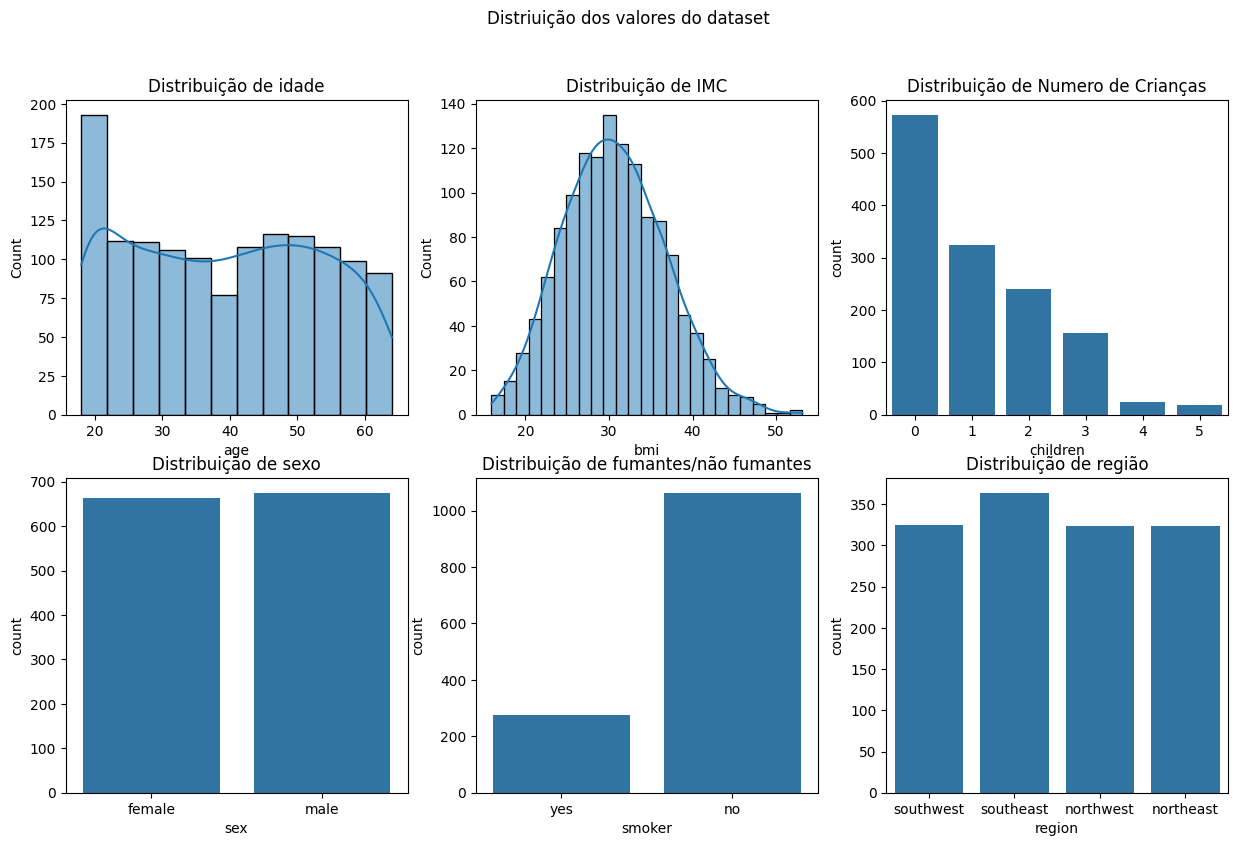

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15,9))
fig.suptitle('Distriuição dos valores do dataset')

sns.histplot(x='age', data=df, kde=True, ax=axes[0, 0])
axes[0,0].set_title('Distribuição de idade')

sns.histplot(df['bmi'], kde=True, ax=axes[0, 1])
axes[0,1].set_title('Distribuição de IMC')

sns.countplot(x='children', data=df, ax=axes[0, 2])
axes[0,2].set_title('Distribuição de Numero de Crianças')

sns.countplot(x='sex', data=df, ax=axes[1, 0])
axes[1,0].set_title('Distribuição de sexo')

sns.countplot(x='smoker', data=df, ax=axes[1, 1])
axes[1,1].set_title('Distribuição de fumantes/não fumantes')

sns.countplot(x='region', data=df, ax=axes[1, 2])
axes[1,2].set_title('Distribuição de região')

Os gráficos acima revelam as distribuições de cada coluna. Percebe-se que as colunas `sex` e `region` possuem distribuições uniformes e bem balanceadas, enquanto há uma clara maioria de não fumantes na base, o que pode dificultar a performance do modelo para predizer corretamente o valor de `charges` para não fumantes.

As variáveis contínuas não seguem uma distribuição perfeitamente normal. `bmi` (IMC, ou índice de massa corpórea, em português) é a que mais se aproxima de tal, mas possui uma "cauda" à sua direita, indicando _outliers_ em seus valores. A variável `age` possui uma distribuição quase uniforme, não fosse pela maior frequência de pessoas com idade próxima a vinte anos. Já a variável `children` possui uma distribuição logaritmica, sendo seu valor cada vez menos provável na base conforme se distancia de 0. Não é possível, porém, afirmar que sua distribuição pode ser considerada categórica, uma vez que não é possível estabelecer um limite o qual seja possível afirmar com certeza que não haverão dados na vida real que ultrapassariam o mesmo.

## Outliers

Text(0.5, 1.0, 'Boxplot de Numero de Crianças')

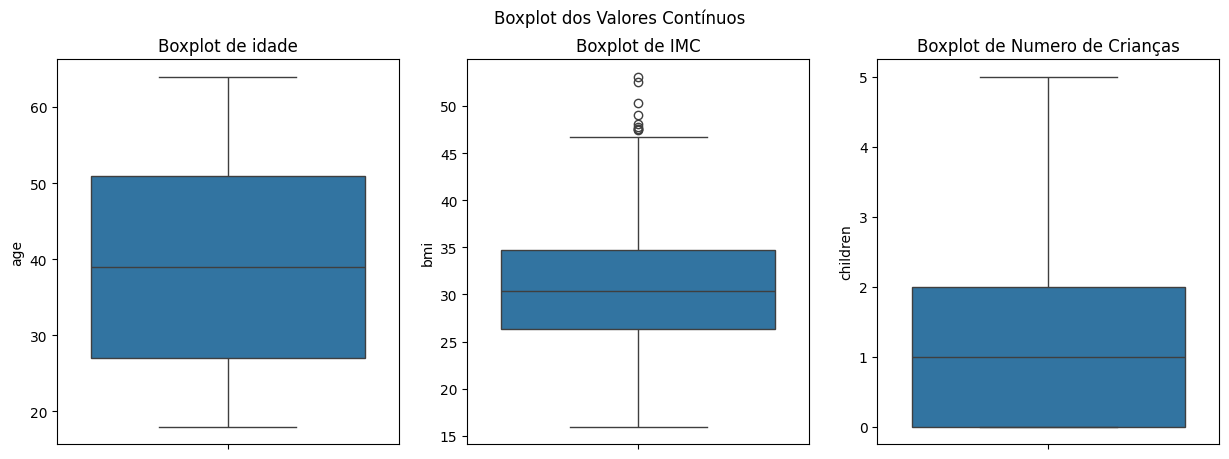

In [ ]:
fig_bp, axes_bp = plt.subplots(1, 3, figsize=(15,5))
fig_bp.suptitle('Boxplot dos Valores Contínuos')

sns.boxplot(df['age'], ax=axes_bp[0])
axes_bp[0].set_title('Boxplot de idade')

sns.boxplot(df['bmi'], ax=axes_bp[1])
axes_bp[1].set_title('Boxplot de IMC')

sns.boxplot(df['children'], ax=axes_bp[2])
axes_bp[2].set_title('Boxplot de Numero de Crianças')

Como esperado, apenas `bmi` possui valores considerados outliers. Seus valores não aparentam ser resultados de erros (má formatação, digitação errônea ou outro método de inserção de dados inválidos), portanto não devem ser removidos. Porém devem ser levados em consideração na hora de escaloná-los e usá-los no treinamento do modelo.

## Correlação de variáveis

Para que possamos calcular a correlação entre as colunas, devemos primeiro transformar as variáveis categóricas existentes em variáveis numéricas.

Através do gráfico de distribuição visto acima, é possível afirmar que as variáveis `sex` e `smoker` possuem apenas dois valores possíveis e, portanto, podem ser convertidas para valores numéricos utilizando a função `LabelEncoder`. Já a variável `region` possui quatro valores possíveis, sendo necessária a função `OneHotEncoder` para a conversão da mesma para valores numéricos.

In [ ]:
df_numerical = df.copy()

In [ ]:
#Transformando colunas de texto em valores numericcos
columns = ['sex', 'smoker']
label_encoder = LabelEncoder()

for column in columns:
    df_numerical[column] = label_encoder.fit_transform(df[column])

df_numerical.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,southwest,16884.92400
1,18,1,33.770,1,0,southeast,1725.55230
2,28,1,33.000,3,0,southeast,4449.46200
3,33,1,22.705,0,0,northwest,21984.47061
4,32,1,28.880,0,0,northwest,3866.85520


In [ ]:
#transformando coluna categorica em colunas booleanas com OneHotEncoder
ohe = OneHotEncoder(sparse_output=False)
ohe.fit(df[['region']])
df_numerical[ohe.categories_[0]] = ohe.transform(df[['region']])

#removendo coluna categórica desnecessária
df_numerical.drop(['region'], axis=1, inplace=True)

df_numerical.head()

,age,sex,bmi,children,smoker,charges,northeast,northwest,southeast,southwest
0,19,0,27.900,0,1,16884.92400,0.0,0.0,0.0,1.0
1,18,1,33.770,1,0,1725.55230,0.0,0.0,1.0,0.0
2,28,1,33.000,3,0,4449.46200,0.0,0.0,1.0,0.0
3,33,1,22.705,0,0,21984.47061,0.0,1.0,0.0,0.0
4,32,1,28.880,0,0,3866.85520,0.0,1.0,0.0,0.0


<Axes: >

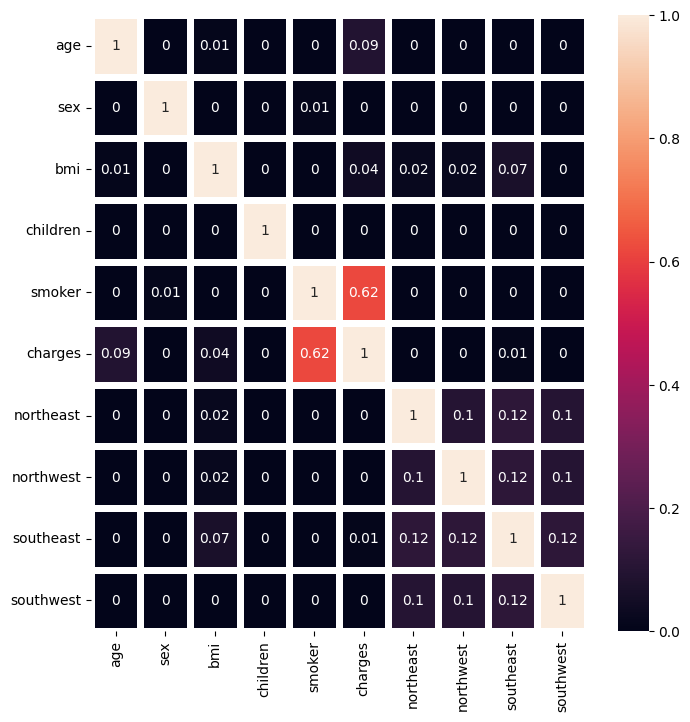

In [ ]:
#Criando grafico de correlação para analise
correlacoes = (df_numerical.corr() ** 2).round(2)

fig, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(correlacoes, annot=True, linewidths=5, ax=ax)

Ao observar a matriz de correlação, pode-se concluir que a variância da variável `smoker` é a que melhor explica a variação da variável dependente `charges`, seguida da variável `age` e `bmi`. O sexo ou a quantidade de crianças de cada amostra não parecem ser relevantes, o que é esperado. Também é possível perceber uma pequena correlação da região sudeste com `charges`, mas tal correlação é pequena a ponto de ser possível desconsiderá-la no treinamento do modelo. Por este motivo, apenas as variáveis `smoker`, `age` e `bmi` serão levadas em consideração no treinamento dos modelos.

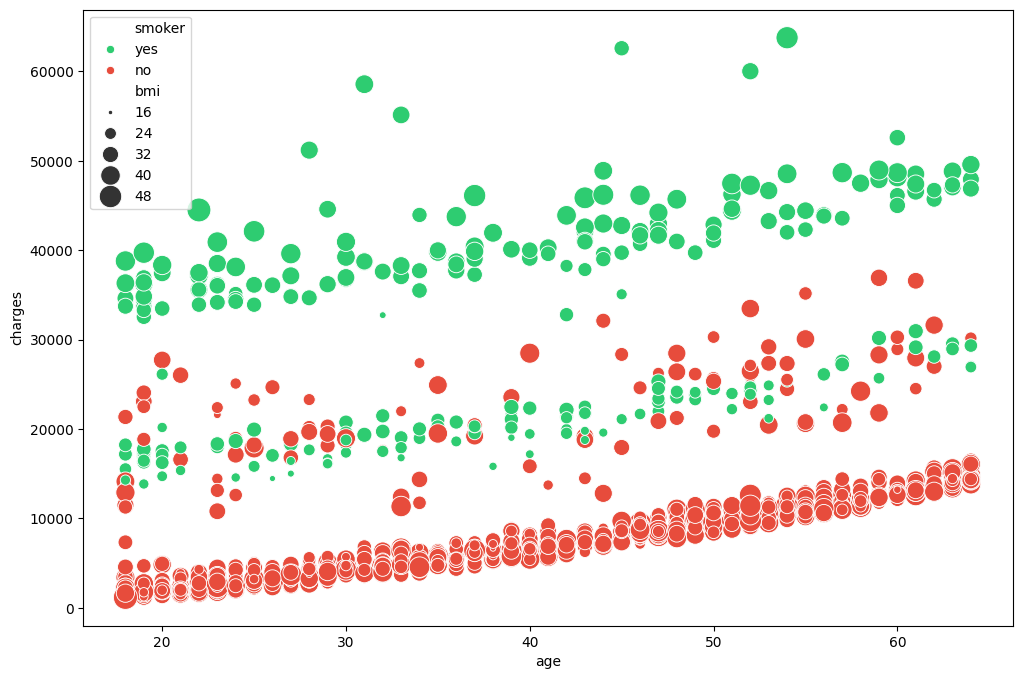

In [ ]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='age', y='charges', hue='smoker', size='bmi', palette=sns.color_palette(["#2ecc71", "#e74c3c"]), sizes=(10, 300), data=df)
plt.show()

O gráfico acima melhor destaca a correlação das variáveis `age`, `smoker` e `bmi` em relação a `charges`. Nele, torna-se claro que há uma tendência positiva no valor cobrado a medida que pessoas envelhecem, tão bem como o claro aumento nos valores para pessoas fumantes em relação a pessoas não fumantes, independente da idade. Já os valores de `bmi` são mais distribuídos e não é possível identificar uma clara correlação entre seu valor e o de `charges`.

## Distribuição da variável dependente

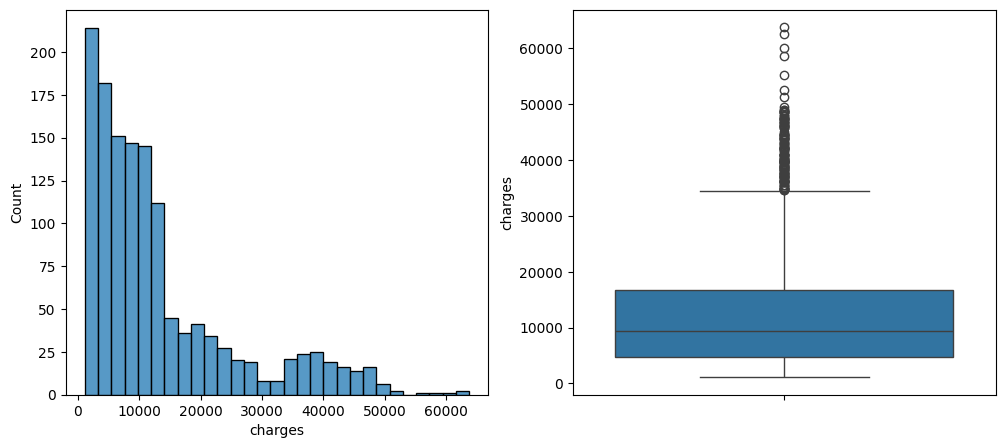

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
sns.histplot(df['charges'])

plt.subplot(1,2,2)
sns.boxplot(df['charges'])
plt.show()

Os gráficos acima demonstram uma clara discrepância nos valores de `charges` obtidos na base de dados, havendo muito mais amostras cujos valores são inferiores a 15 mil do que superiores ao mesmo valor. Isso deve ser levado em consideração na hora de treinar o modelo, caso contrário o mesmo pode sofrer `overfit` ao prever valores mais baixos uma vez que estes são a maioria e, portanto, levariam a um melhor _score_

# Treinamento de modelos

Três modelos foram selecionados para realizar a previsão de `charges`:
- Regressão linear utilizando `LinearRegression`
- KNN utilizando `KNeighborsRegressor`
- SVM utilizando `SVR`

Para todos, a divisão entre dados de treino e teste utilizada foi a mesma, de forma a melhor comparar a performance de cada modelo.

Observe que a função `train_test_split` fora utilizada com a variável `df` e não com `df_numerical`.

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
X_train = df_train[['age', 'bmi', 'smoker']]
y_train = df_train['charges']

X_test = df_test[['age', 'bmi', 'smoker']]
y_test = df_test['charges']

## Modelo de Regressão Linear

In [ ]:
X_train_lin = X_train.copy()
y_train_lin = y_train.copy()

X_test_lin = X_test.copy()
y_test_lin = y_test.copy()

### Tratamento dos Dados

#### Escalonamento de Variáveis continuas

Dada a discrepância de magnitude dos valores de cada coluna da base, vê-se necessário o escalonamento de tais valores para evitar que o modelo dê maior relevância a colunas de maior magnitude. Deste modo, o modelo convergirá mais rapidamente e os coeficientes angulares calculados para cada uma das variáveis poderão ser comparados e uma melhor análise pode ser realizada.

Como `LinearRegression` não é um modelo treinado com base em distância (como é o caso de `KNeighborsRegressor` e `SVR`), o escalonamento pode ser feito utilizando diferentes técnicas para cada coluna. Desta forma, apesar das escalas não serem as mesmas, será possível escalonar cada coluna utilizando a melhor técnica de acordo com sua distribuição, além dos valores escalados serem próximos o suficiente dentre as colunas para que os benefícios do escalonamento (convergência e comparação) sejam aproveitados.

In [ ]:
X_train_lin_transformed = X_train_lin.copy()
X_test_lin_transformed = X_test_lin.copy()

In [ ]:
std_columns = ['age']
std = StandardScaler()
std.fit(X_train_lin[std_columns])
X_train_lin_transformed[std_columns] = std.transform(X_train_lin[std_columns])
X_test_lin_transformed[std_columns] = std.transform(X_test_lin[std_columns])

In [ ]:
rbs_columns = ['bmi']
rbs = RobustScaler()
rbs.fit(X_train_lin[rbs_columns])
X_train_lin_transformed[rbs_columns] = rbs.transform(X_train_lin[rbs_columns])
X_test_lin_transformed[rbs_columns] = rbs.transform(X_test_lin[rbs_columns])

#### Conversão de variáveis categóricas para contínuas

Como apenas a variável categórica `smoker` será utilizada, é possível utilizar o método `LabelEncoder` para conversão:

In [ ]:
lec_column = 'smoker'
lec = LabelEncoder()
lec.fit(X_train_lin[lec_column])
X_train_lin_transformed[lec_column] = lec.transform(X_train_lin[lec_column])
X_test_lin_transformed[lec_column] = lec.transform(X_test_lin[lec_column])

In [ ]:
X_train_lin_transformed.head()

,age,bmi,smoker
1114,-1.157680,-0.689697,0
968,-1.300619,-0.540000,0
599,0.914926,0.887879,0
170,1.701087,1.366061,0
275,0.557580,-0.436364,0


#### Pipelines e ColumnTransformes

Uma maneira mais simples e sucinta de obter o mesmo resultado da transformação acima é através de [`Pipelines`](https://scikit-learn.org/1.5/modules/generated/sklearn.pipeline.Pipeline.html) (para operações sequenciais) e [`ColumnTransformers`](https://scikit-learn.org/1.5/modules/generated/sklearn.compose.ColumnTransformer.html) (para operações em paralelo). Desta forma, uma estrutura única é criada e é possível executar `.fit()` uma única vez para todos os processos.

No entanto, utilizar `LabelEncoder` dentro de um `Pipeline` resulta em um erro devido ao formato esperado pelo mesmo ser diferente do fornecido pelo `Pipeline`. Por este motivo, a função `LabelEncoder` fora subsitituida por `OrdinalEncoder` abaixo.

In [ ]:
# criação de um Pipeline para executar a transformação de StandardScaler
std_pipe_lin = Pipeline([
    ('std', StandardScaler())
])

# criação de um Pipeline para executar a transformação de RobustScaler
rbs_pipe_lin = Pipeline([
    ('rbs', RobustScaler())
])

# criação de um Pipeline para executar a transformação de LabelEncoder
cat_pipe_lin = Pipeline([
    ('lec', OrdinalEncoder(categories=[['no', 'yes']]))
])

# paralelização das transformações
transformer_lin = ColumnTransformer([
    ('std_pipe', std_pipe_lin, ['age']),    # utilize RobustScaler apenas na coluna 'age'
    ('rbs_pipe', rbs_pipe_lin, ['bmi']),    # utilize StandardScaler apenas na coluna 'bmi'
    ('cat_pipe', cat_pipe_lin, ['smoker'])  # utilize RobustScaler apenas na coluna 'smoker'
])
transformer_lin.fit(X_train_lin)

column_names = transformer_lin.get_feature_names_out()
X_train_lin_transformed = transformer_lin.transform(X_train_lin)
pd.DataFrame(X_train_lin_transformed, columns=column_names)

,std_pipe__age,rbs_pipe__bmi,cat_pipe__smoker
0,-1.157680,-0.689697,0.0
1,-1.300619,-0.540000,0.0
2,0.914926,0.887879,0.0
3,1.701087,1.366061,0.0
4,0.557580,-0.436364,0.0
...,...,...,...
1064,0.843457,0.576970,1.0
1065,-0.871804,1.903030,0.0
1066,-1.372088,-0.993939,0.0
1067,-0.085643,-0.266667,0.0


### Treinamento do Modelo

Para avaliar a precisão deste e dos outros modelos, a métrica de _Mean Absolute Error_ (MAE) será utilizada. Isto porque, como visto acima, a variável dependente `charges` possui valores muito discrepantes, tornando-se necessário uma métrica de avaliação mais robusta a _outliers_.

Através do método de `GridSearch`, utilizado para testar diferentes hiperparâmetros a fim de arranjar a combinação que gera o **maior `score`**, é possível aplicar a técnica de MAE através do parâmetro `scoring='neg_mean_absolute_error'`. Isto porque, como o `GridSearch` sempre considera um *score* maior como sendo melhor, e como um MAE menor indica um modelo mais preciso, o MAE negativo deve ser utilizado para corretamente testar a performance do modelo.

In [ ]:
grid_search_lin = GridSearchCV(
    LinearRegression(),
    param_grid={
        'fit_intercept': [True, False]
    },
    cv=5,
    scoring='neg_mean_absolute_error')

grid_search_lin.fit(X_train_lin_transformed, y_train_lin)

grid_search_lin.best_params_

{'fit_intercept': True}

In [ ]:
best_lin = grid_search_lin.best_estimator_

Além do processo de tratamento de dados, também é possível adicionar a etapa de treinamento e execução de modelo ao `Pipeline` criado acima. Sendo uma etapa que sucede a fase de transformação, é possível adicionar o modelo de regressão linear da seguinte forma:

In [ ]:
final_pipe_lin = Pipeline([
    ('preprocessing', transformer_lin),
    ('model', best_lin)
])
final_pipe_lin.fit(X_train_lin, y_train_lin)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('std_pipe',
                                                  Pipeline(steps=[('std',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('rbs_pipe',
                                                  Pipeline(steps=[('rbs',
                                                                   RobustScaler())]),
                                                  ['bmi']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('lec',
                                                                   OrdinalEncoder(categories=[['no',
                                                                                               'yes']]))]),
                                                  ['smoker'])])),
                ('model', LinearRegression())])

In [ ]:
cross_val_score(final_pipe_lin, X=X_train_lin, y=y_train_lin, cv=5, scoring='neg_mean_absolute_error').mean()

-4244.347674658734

O valor acima indica que o modelo de regressão tem um MAE de **4224**, ou seja, seus valores previstos tem um erro médio de 4224 unidades a mais ou a menos em comparação ao valor real.

### Avaliação do Modelo

In [ ]:
y_pred_lin = final_pipe_lin.predict(X_test_lin)
rmse_lin = root_mean_squared_error(y_test_lin, y_pred_lin)
mae_lin  = mean_absolute_error(y_test_lin, y_pred_lin)
r2_lin   = r2_score(y_test_lin, y_pred_lin)
print("Média do erro quadrada: ", rmse_lin)
print("Média do erro absoluta: ", mae_lin)
print("R quadrada: ", r2_lin)

Média do erro quadrada:  5986.783344847842
Média do erro absoluta:  4191.704294603893
R quadrada:  0.8049502474643172


## Modelo de KNN

In [ ]:
X_train_knn = X_train.copy()
y_train_knn = y_train.copy()

X_test_knn = X_test.copy()
y_test_knn = y_test.copy()

### Tratamento dos Dados

Sendo um modelo baseado na distância entre os pontos, torna-se preferível escalonar as variáveis contínuas usando uma mesma técnica. Dado que a variável `bmi` possui outliers, a técnica de `RobustScaler` será utilizada.

In [ ]:
num_pipe_knn = Pipeline([
    ('scaler', RobustScaler())
])

cat_pipe_knn = Pipeline([
    ('encoder', OrdinalEncoder(categories=[['no', 'yes']])),
    ('scaler', RobustScaler())
])

transformer_knn = ColumnTransformer([
    ('num_pipe', num_pipe_knn, ['age', 'bmi']),
    ('cat_pipe', cat_pipe_knn, ['smoker'])
])
transformer_knn.fit(X_train_knn)

column_names = transformer_knn.get_feature_names_out()
X_train_knn_transformed = transformer_knn.transform(X_train_knn)
pd.DataFrame(X_train_knn_transformed, columns=column_names)

,num_pipe__age,num_pipe__bmi,cat_pipe__smoker
0,-0.666667,-0.689697,0.0
1,-0.750000,-0.540000,0.0
2,0.541667,0.887879,0.0
3,1.000000,1.366061,0.0
4,0.333333,-0.436364,0.0
...,...,...,...
1064,0.500000,0.576970,1.0
1065,-0.500000,1.903030,0.0
1066,-0.791667,-0.993939,0.0
1067,-0.041667,-0.266667,0.0


###Treinamento do Modelo

O modelo de `KNN` pode ser verificado com um único hiperparâmetro, `n_neighbors`. Encontrar `n_neighbors` ótimo não significa apenas checar sua performance, mas também encontrar o valor mínimo o qual valores maiores que ele resultariam em aumento de performance irrelevante ou até mesmo perda de performance.

In [ ]:
knn = KNeighborsRegressor()
grid_search_knn = GridSearchCV(knn,
                               param_grid={'n_neighbors': range(1, 11)},
                               cv=4,
                               scoring='neg_mean_absolute_error',
                               return_train_score=True)
grid_search_knn.fit(X_train_knn_transformed, y_train_knn)

print('Best score for data:', grid_search_knn.best_score_)
print('Best N:',grid_search_knn.best_estimator_.n_neighbors)

Best score for data: -2910.3889408766286
Best N: 9


Para validar se o valor encontrado de fato é o ótimo ou se valores menores podem ser utilizados sem perda significativa de performance, é possível gerar um gráfico com o valor médio obtido para cada `n_neighbors`

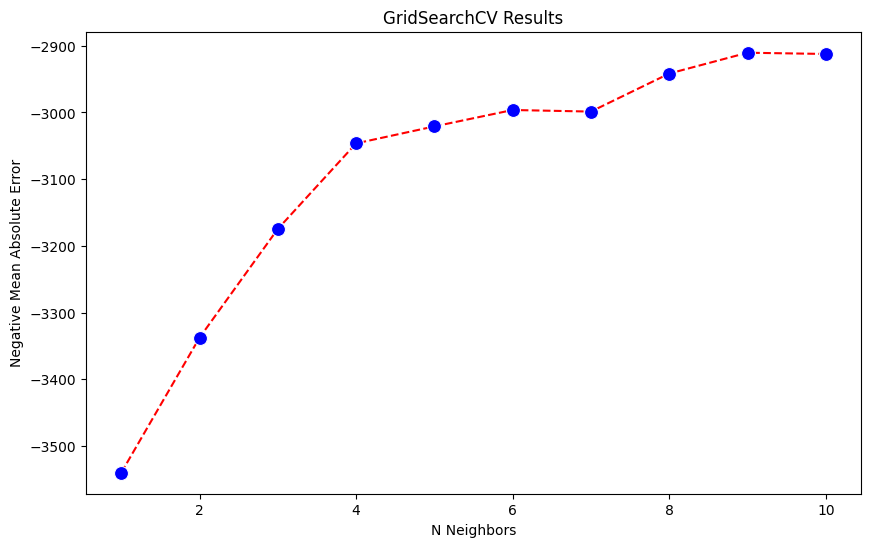

In [ ]:
results = pd.DataFrame(grid_search_knn.cv_results_)

plt.figure(figsize=(10, 6))
sns.lineplot(x='param_n_neighbors', y='mean_test_score', data=results, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10)
plt.xlabel('N Neighbors')
plt.ylabel('Negative Mean Absolute Error')
plt.title('GridSearchCV Results')
plt.show()

Como esperado, o valor de `n_neighbors` indicado pelo método de `GridSearch` é o que melhor performa, com o valor seguinte sendo pior. O valor anterior (8) possui uma performance similar e poderia ser utilizado caso fosse necessário reduzir a complexidade do modelo. No entanto, devido à simplicidade do mesmo, o modelo obtido pelo `GridSearch` será utilizado.

In [ ]:
best_knn = grid_search_knn.best_estimator_

final_pipe_knn = Pipeline([
    ('preprocessing', transformer_knn),
    ('model', best_knn)
])
final_pipe_knn.fit(X_train_knn, y_train_knn)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'bmi']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder(categories=[['no',
                                                                                               'yes']])),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['smoker'])])),
                ('model', KNeighborsRegressor(n_neighbors=9))])

In [ ]:
cross_val_score(final_pipe_knn, X=X_train_knn, y=y_train_knn, cv=5, scoring='neg_mean_absolute_error').mean()

-2913.7865703122143

### Avaliação do Modelo

In [ ]:
y_pred_knn = final_pipe_knn.predict(X_test_knn)
rmse_knn = root_mean_squared_error(y_test_knn, y_pred_knn)
mae_knn  = mean_absolute_error(y_test_knn, y_pred_knn)
r2_knn   = r2_score(y_test_knn, y_pred_knn)
print("Média do erro quadrada: ", rmse_knn)
print("Média do erro absoluta: ", mae_knn)
print("R quadrada: ", r2_knn)

Média do erro quadrada:  4502.907348963156
Média do erro absoluta:  2600.789058263267
R quadrada:  0.8896571130909107


## Modelo de SVM

In [ ]:
X_train_svr = X_train.copy()
y_train_svr = y_train.copy()

X_test_svr = X_test.copy()
y_test_svr = y_test.copy()

### Tratamento dos Dados

Assim como o `KNN`, o modelo de `SVM` também trabalha com a distância entre os pontos. Devido a isso, o mesmo tratamento dos dados utilizado para o `KNN` pode ser utilizado em `SVM`.

In [ ]:
num_pipe_svr = Pipeline([
    ('scaler', RobustScaler())
])

cat_pipe_svr = Pipeline([
    ('encoder', OrdinalEncoder(categories=[['no', 'yes']])),
    ('scaler', RobustScaler())
])

transformer_svr = ColumnTransformer([
    ('num_pipe', num_pipe_svr, ['age', 'bmi']),
    ('cat_pipe', cat_pipe_svr, ['smoker'])
])
transformer_svr.fit(X_train_svr)

column_names = transformer_svr.get_feature_names_out()
X_train_svr_transformed = transformer_svr.transform(X_train_svr)
pd.DataFrame(X_train_svr_transformed, columns=column_names)

,num_pipe__age,num_pipe__bmi,cat_pipe__smoker
0,-0.666667,-0.689697,0.0
1,-0.750000,-0.540000,0.0
2,0.541667,0.887879,0.0
3,1.000000,1.366061,0.0
4,0.333333,-0.436364,0.0
...,...,...,...
1064,0.500000,0.576970,1.0
1065,-0.500000,1.903030,0.0
1066,-0.791667,-0.993939,0.0
1067,-0.041667,-0.266667,0.0


### Treinamento do Modelo

O modelo de `SVM` é potencialmente um dos que mais se beneficia com a técnica de `GridSearch` para ajuste de seus hiperparâmetros, dada a grande gama de possibilidades que o modelo oferece.

A execução abaixo visa validar, dentre todos os cenários de parametrização de `C` (Parâmetro de Regularização) e `Gamma` (Coeficiente de Kernel), qual é o que performa melhor dado 3 possibilidades de Kernels ("rbf", "linear" e "poly"). O hiperparâmetro `degree` também fora verificado para o kernel polinomial.

Para diluir o espectro de possibilidades dos parâmetros `C` e `gamma`, a técnica de `logspace` fora utilizada.

In [ ]:
c_range = np.logspace(-0, 4, 8)
gamma_range = np.logspace(-4, 0, 8)

tuned_parameters = [{'kernel': ['rbf'],    'C': c_range, 'gamma': gamma_range},
                    {'kernel': ['linear'], 'C': c_range, 'gamma': gamma_range},
                    {'kernel': ['poly'],   'C': c_range, 'gamma': gamma_range, 'degree': [2, 3]}]

svr = SVR(epsilon=0.1)
grid_search_svr = GridSearchCV(svr,
                               param_grid=tuned_parameters,
                               n_jobs=-1,
                               cv=4,
                               scoring='neg_mean_absolute_error',
                               return_train_score=True)
grid_search_svr.fit(X_train_svr_transformed, y_train_svr)

print('Best score for data:', grid_search_svr.best_score_)
print('Best C:', grid_search_svr.best_estimator_.C)
print('Best Kernel:', grid_search_svr.best_estimator_.kernel)
print('Best Gamma:', grid_search_svr.best_estimator_.gamma)

Best score for data: -2249.26876351318
Best C: 10000.0
Best Kernel: rbf
Best Gamma: 1.0


Para melhor visualizar e comparar o crescimento dos parâmetros em relação a todos os kernels, dois gráficos de `Lineplot` foram produzidos a fim de avaliar se os parâmetros obtidos pelo `GridSearch` de fato possuem valores ótimos ou se a tendência revelada indicaria outros valores a serem adicionados ao teste.

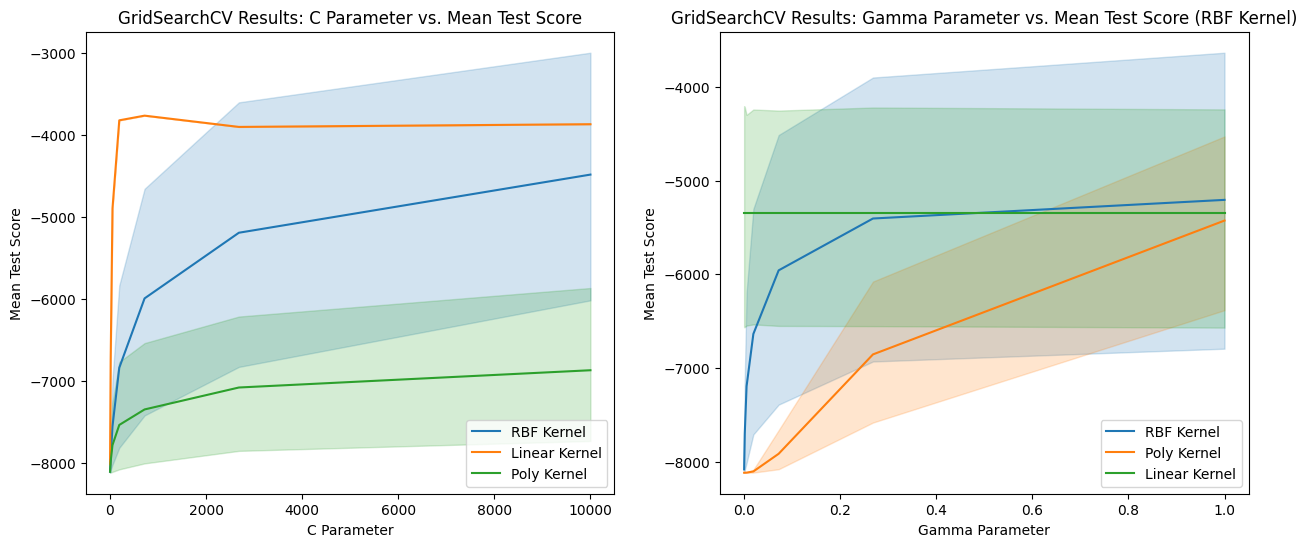

In [ ]:
results = pd.DataFrame(grid_search_svr.cv_results_)

# LINEPLOT Para parâmetro C
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
sns.lineplot(x='param_C', y='mean_test_score', data=results[results['param_kernel'] == 'rbf'], label='RBF Kernel')
sns.lineplot(x='param_C', y='mean_test_score', data=results[results['param_kernel'] == 'linear'], label='Linear Kernel')
sns.lineplot(x='param_C', y='mean_test_score', data=results[results['param_kernel'] == 'poly'], label='Poly Kernel')
plt.xlabel('C Parameter')
plt.ylabel('Mean Test Score')
plt.title('GridSearchCV Results: C Parameter vs. Mean Test Score')
plt.legend(loc='lower right')

# LINEPLOT Para parâmetro GAMMA
plt.subplot(1,2,2)
sns.lineplot(x='param_gamma', y='mean_test_score', data=results[results['param_kernel'] == 'rbf'], label='RBF Kernel')
sns.lineplot(x='param_gamma', y='mean_test_score', data=results[results['param_kernel'] == 'poly'], label='Poly Kernel')
sns.lineplot(x='param_gamma', y='mean_test_score', data=results[results['param_kernel'] == 'linear'], label='Linear Kernel')
plt.xlabel('Gamma Parameter')
plt.ylabel('Mean Test Score')
plt.title('GridSearchCV Results: Gamma Parameter vs. Mean Test Score (RBF Kernel)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Execução do modelo que melhor performou
best_svr = grid_search_svr.best_estimator_

final_pipe_svr = Pipeline([
    ('preprocessing', transformer_svr),
    ('model', best_svr)
])
final_pipe_svr.fit(X_train_svr, y_train_svr)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'bmi']),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder(categories=[['no',
                                                                                               'yes']])),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['smoker'])])),
                ('model', SVR(C=10000.0, gamma=1.0))])

In [ ]:
cross_val_score(final_pipe_svr, X=X_train_svr, y=y_train_svr, cv=5, scoring='neg_mean_absolute_error').mean()

-2217.3895269941268

### Avaliação do Modelo

In [ ]:
y_pred_svr = final_pipe_svr.predict(X_test_svr)
rmse_svr = root_mean_squared_error(y_test_svr, y_pred_svr)
mae_svr  = mean_absolute_error(y_test_svr, y_pred_svr)
r2_svr   = r2_score(y_test_svr, y_pred_svr)
print("Média do erro quadrada: ", rmse_svr)
print("Média do erro absoluta: ", mae_svr)
print("R quadrada: ", r2_svr)

Média do erro quadrada:  4578.169873158989
Média do erro absoluta:  2000.0649883691779
R quadrada:  0.8859376995427335


# Discussão dos Resultados

## Comparação de Performance

A tabela abaixo reúne a avaliação final de cada um dos modelos para comparação

In [ ]:
lin_performance = [rmse_lin, mae_lin, r2_lin]
knn_performance = [rmse_knn, mae_knn, r2_knn]
svm_performance = [rmse_svr, mae_svr, r2_svr]
pd.DataFrame([lin_performance, knn_performance, svm_performance], columns=['Root Mean Squared Error', 'Mean Absolute Error', 'R2 Score'], index=['Lin', 'KNN', 'SVM'])

,Root Mean Squared Error,Mean Absolute Error,R2 Score
Lin,5986.783345,4191.704295,0.804950
KNN,4502.907349,2600.789058,0.889657
SVM,4578.169873,2000.064988,0.885938


Através da mesma, é possível perceber que o modelo `SVR` teve uma performance melhor que os demais, embora o modelo `KNN` tenha tido uma performance similar. Já o modelo `LinearRegression` foi o que pior performou.

## Curvas de Aprendizado

Além das métricas de avaliação, também é importante verificar as curvas de aprendizado de cada modelo, a fim de analisar se algum deles sofre _underfitting_ ou _overfitting_.

In [ ]:
def plot_learning_curve(estimator, X, y, title):
  train_sizes, train_scores, test_scores = learning_curve(estimator=estimator, X=X, y=y, train_sizes=np.linspace(0.1, 1.0, 20), cv=5, scoring='neg_mean_absolute_error')

  # Take the mean of cross-validated train scores and validation scores
  train_scores_mean = np.mean(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)

  plt.plot(train_sizes, train_scores_mean, label = 'Performance de Treino')
  plt.plot(train_sizes, test_scores_mean, label = 'Performance de Teste')
  plt.ylim([-5000, -2000])
  plt.ylabel('r2 score', fontsize = 10)
  plt.xlabel('Amostras utilizadas para treino', fontsize = 10)
  plt.title(title, fontsize = 14)
  plt.legend(loc="lower right")

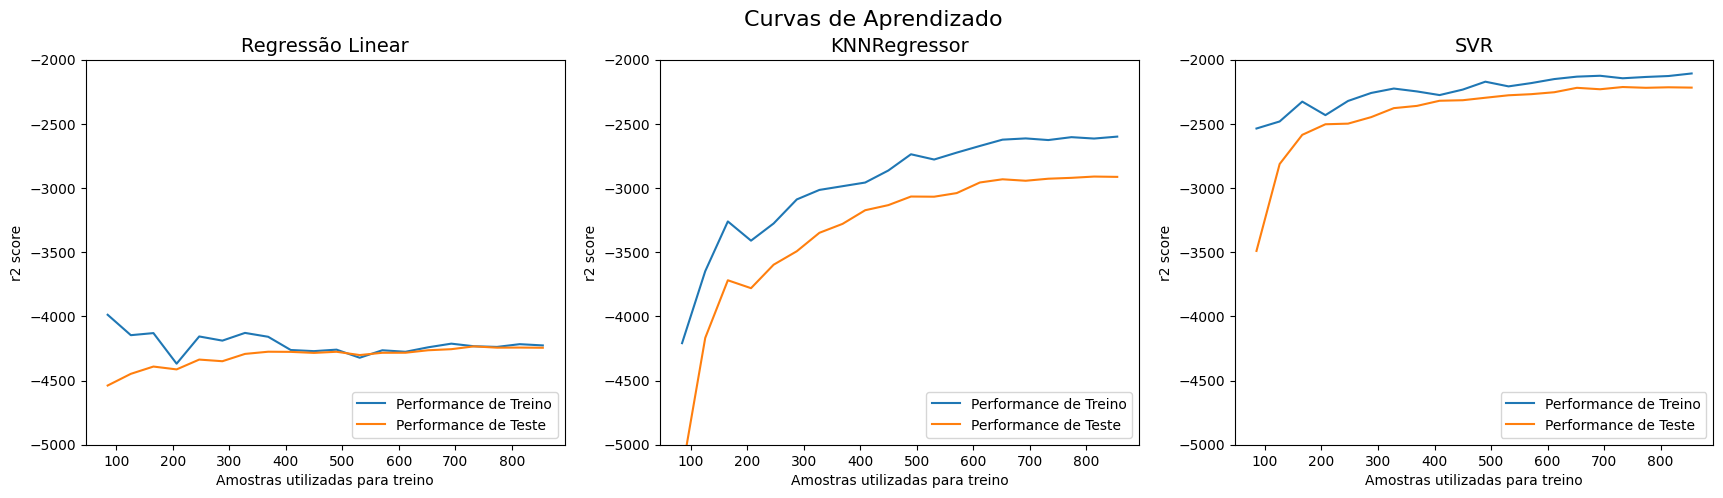

In [ ]:
plt.figure(figsize=(21, 5))
plt.suptitle('Curvas de Aprendizado', fontsize = 16)
plt.subplot(1,3,1)
plot_learning_curve(final_pipe_lin, X_train_lin, y_train_lin, 'Regressão Linear')

plt.subplot(1,3,2)
plot_learning_curve(final_pipe_knn, X_train_knn, y_train_knn, 'KNNRegressor')

plt.subplot(1,3,3)
plot_learning_curve(final_pipe_svr, X_train_svr, y_train_svr, 'SVR')

Com base nos gráficos acima, pode-se concluir que todos os modelos não parecem sofrer de _underfitting_ ou _overfitting_, uma vez que suas performances de treino e teste são similares (indicando que não há _overfitting_) e possuem bons _scores_ (indicando que não há _underfitting_). No entanto, é importante lembrar que a base de dados não possui muitas amostras com o valor de `charges` elevado, o que não só pode levar a um potencial _overfitting_ do modelo em favor à previsão de valores mais baixos quanto impede que tal enviezamento seja relatado nos gráficos acima.

## Plots Residuais

Os gráficos abaixo relacionam o valor real de `charges` com o valor residual da previsão feita, isto é, a diferença entre o valor real e o valor previsto. Desta forma, é possível verificar com maior clareza como cada modelo performa conforme o valor real de `charges` aumenta.

In [ ]:
def plot_residuals(y_test, y_pred, title):
  residuals = y_test - y_pred
  sns.scatterplot(x=y_test, y=residuals)
  plt.title(title)
  plt.xlabel('Real Charges')
  plt.ylabel('Residuals')
  plt.axhline(y=0, color='r', linestyle='--')

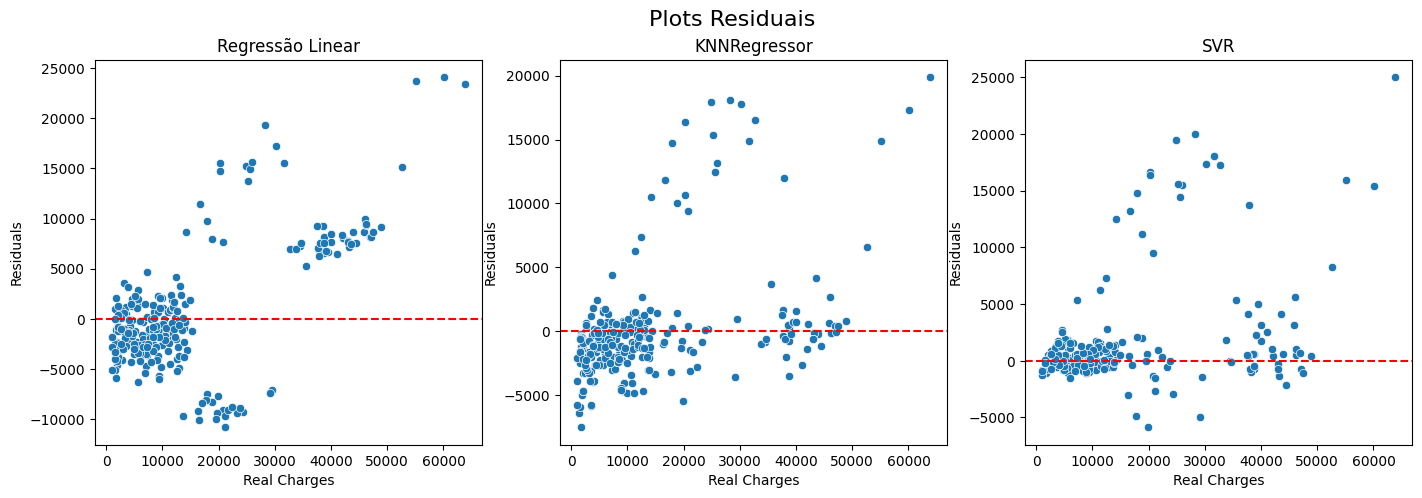

In [ ]:
plt.figure(figsize=(17, 5))
plt.suptitle('Plots Residuais', fontsize = 16)
plt.subplot(1,3,1)
plot_residuals(y_test_lin, y_pred_lin, 'Regressão Linear')

plt.subplot(1,3,2)
plot_residuals(y_test_knn, y_pred_knn, 'KNNRegressor')

plt.subplot(1,3,3)
plot_residuals(y_test_svr, y_pred_svr, 'SVR')

Como esperado, parece haver uma tendência proporcional entre o valor real de `charges` e o valor residual, indicando que quanto maior o valor real, mais distante o valor previsto. No entanto, nos gráficos de `KNN` e `SVM` é possível observar tanto resíduos relativamente baixos para valores reais maiores de 30 mil quanto resíduos altos através de todo o intervalo de valores reais, e embora o modelo de `LinearRegression` não possua resíduos baixos para valores maiores, em seu gráfico também é possível encontrar resíduos discrepantes. Tais discrepâncias podem ser apontar _outliers_ nas amostras, isto é, por mais que a amostra possua valores individuais que não sejam considerados _outliers_, a combinação de suas informações não reflete o valor final cobrado (por exemplo, uma pessoa jovem, não fumante e com IMC próximo a 30 ter sido cobrada um valor exorbitante).

# Conclusão

## Dados

Com apenas três colunas relevantes para a previsão de `charges` e menos de 1500 amostras, foi uma surpresa obter resultados tão elevados. Devido às discrepâncias observadas nos gráficos residuais, pode-se considerar a obtenção de novas _features_ relevantes ao problema, tais como condições pré-existentes de saúde, categoria no serviço de seguro contratado, companhia que oferece o seguro, entre outros. Tais informações poderiam revelar novos padrões ao modelo e, junto à coleta de mais amostras, poderiam levar a modelos com muito mais precisão do que os obtidos neste trabalho.

## Modelos

Apesar da base de dados ser relativamente pequena tanto em amostras quanto informações de cada amostra, os modelos de `KNN` e `SVM` se mostraram satisfatórios, com `r2` de quase 0.89, ou seja, 89% da variância de `charges` pôde ser explicada pela variância de tais modelos. No entanto, a performance ainda está longe da ideal, com o menor erro absoluto médio alcançando 2 mil, uma discrepância considerada alta dada que a maioria dos valores reais circundam a casa dos 10 mil (ou seja, em média erra-se o valor em 20% para tais amostras).

Já o modelo de `LinearRegression`, por sua simplicidade e falta de recursos (amostras e _features_) teve uma performance inferior aos demais e foi melhor utilizado como uma base a qual os outros dois modelos deveriam superar. Isso já era esperado devido à não-linearidade do problema.